In [4]:
import json
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, BartTokenizer, BartModel, RobertaTokenizer, RobertaForSequenceClassification
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [5]:
def get_token_index(tokens, start):
    char_index = 0
    
    for i, token in enumerate(tokens):
        token_start = char_index
        token_end = char_index + len(token)
        
        if token_start <= start and start <= token_end:
            return i
        
        char_index = token_end + 1
    
    return -1

In [6]:
def preprocessing(input_file, output_file):  
    with open(input_file, 'r', encoding='utf-8') as file:
        data = json.load(file)

    preprocessed_data = []

    for item in data:
        sentence = item['sentence']
        tokens = sentence.split()
        aspect_terms = item['aspect_terms']

        for aspect_term in aspect_terms:
            start = int(aspect_term['from'])
            end = int(aspect_term['to'])
            index = get_token_index(tokens, start)

            preprocessed_item = {
                'tokens': tokens,
                'polarity': aspect_term['polarity'],
                'aspect_term': aspect_term['term'].split(),
                'index': index
            }
            preprocessed_data.append(preprocessed_item)

    with open(output_file, 'w', encoding='utf-8') as out_file:
        json.dump(preprocessed_data, out_file, indent=4, ensure_ascii=False)
        
preprocessing('train.json', 'train_task_2.json')
preprocessing('val.json', 'val_task_2.json')

In [7]:
class ABSADataset(Dataset):
    def __init__(self, data, label_map, bert_model="bert-base-uncased", max_len_sentence=35, max_len_aspect=3):
        """
        Args:
            data (list): List of dicts with 'tokens', 'aspect', and 'polarity'.
            label_map (dict): Mapping of sentiment labels to integers.
            bert_model (str): Pretrained BERT model name.
            max_len (int): Max sequence length for tokenization.
        """
        self.data = data
        self.label_map = label_map
        self.tokenizer = BertTokenizer.from_pretrained(bert_model)
        self.bert_model = BertModel.from_pretrained(bert_model)
        self.max_len_sentence = max_len_sentence
        self.max_len_aspect = max_len_aspect

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        sentence = " ".join(item["tokens"])  # Convert tokens to a full sentence
        aspect = " ".join(item["aspect_term"])
        polarity = self.label_map[item["polarity"]]

        # Tokenize sentence
        sentence_inputs = self.tokenizer(sentence, padding="max_length", truncation=True,
                                         max_length=self.max_len_sentence, return_tensors="pt")
        
        # Tokenize aspect
        aspect_inputs = self.tokenizer(aspect, padding="max_length", truncation=True,
                                       max_length=self.max_len_aspect, return_tensors="pt")

        # Compute BERT embeddings (disable gradients for efficiency)
        with torch.no_grad():
            sentence_embedding = self.bert_model(**sentence_inputs).last_hidden_state.squeeze(0)  # [seq_len, emb_dim]
            aspect_embedding = self.bert_model(**aspect_inputs).last_hidden_state[:, 0, :]  # CLS token

        return sentence_embedding, aspect_embedding, torch.tensor(polarity, dtype=torch.long)

In [8]:
class ABSAModel(nn.Module):
    def __init__(self, embedding_dim=768, hidden_size=128, aspect_dim=768, num_lstm_layers=1, dropout = 0.5):
        super(ABSAModel, self).__init__()
        self.hidden_size = hidden_size

        # GRU (Processes BERT word embeddings)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=num_lstm_layers, batch_first=True)
        # Attention mechanism (Concatenating hidden states with aspect embeddings)
        self.attention = nn.Linear(hidden_size + aspect_dim, 1, bias=False)  # GRU outputs 2*hidden_size

        # Transformation Layer Before Softmax
        self.fc_hidden = nn.Linear(hidden_size, hidden_size)  
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(hidden_size)

        # Final output layer (4 sentiment classes: pos, neg, neutral, conflict)
        self.fc_output = nn.Linear(hidden_size, 4)

    def forward(self, word_embeddings, aspect_embeddings):
        """
        sentences: [batch_size, seq_len]
        aspects: [batch_size] (aspect terms as indices)
        """
        batch_size, seq_len, _ = word_embeddings.shape  

        # GRU Processing
        lstm_out, _ = self.gru(word_embeddings)  # Output shape: [batch_size, seq_len, hidden_size * 2]
        # lstm_out = self.norm(lstm_out)
        # Concatenate Aspect Embedding with GRU Hidden States
        aspect_repeated = aspect_embeddings.expand(-1, seq_len, -1)
        
        # Concatenate GRU output with aspect embeddings
        att_input = torch.cat([lstm_out, aspect_repeated], dim=-1)  # [batch_size, seq_len, hidden_size + aspect_dim]
        
        # Compute Aspect-aware Attention Scores
        att_weights = torch.tanh(self.attention(att_input))  # [batch_size, seq_len, 1]
        att_weights = torch.softmax(att_weights, dim=1)  # Normalize across sequence
        
        # Compute Weighted Sum of GRU Hidden States
        weighted_sum = torch.sum(lstm_out * att_weights, dim=1)  # [batch_size, hidden_size]
        
        # Fully Connected Transformation Layer
        transformed_features = self.fc_hidden(weighted_sum)  # [batch_size, hidden_size // 2]
        transformed_features = self.activation(transformed_features)  # Non-linearity
        transformed_features = self.dropout(transformed_features)  
        
        # Sentiment Prediction (Softmax over Output)
        output = self.fc_output(transformed_features)  # [batch_size, output_dim]
        
        return output

In [9]:
def train(train_dataloader, val_dataloader, model, num_epochs, lr, device):
    
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    train_loss_list = []
    val_loss_list = []
    best_val_loss = float("inf")
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for batch in train_dataloader:
            tokens, aspect, labels = batch  # Extract batch components
            tokens, aspect, labels = tokens.to(device), aspect.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(tokens, aspect)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            # Track metrics
            train_loss += loss.item()
            _, predicted = torch.max(outputs, dim=1)  # Get predicted class
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        train_acc = train_correct / train_total
        avg_train_loss = train_loss / len(train_dataloader)

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for batch in val_dataloader:
                tokens, aspect, labels = batch
                tokens, aspect, labels = tokens.to(device), aspect.to(device), labels.to(device)

                outputs = model(tokens, aspect)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, dim=1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        avg_val_loss = val_loss / len(val_dataloader)

        train_loss_list.append(avg_train_loss)
        val_loss_list.append(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'ABSAModel.pth')

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
        f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
    return train_loss_list, val_loss_list

In [10]:
with open('train_task_2.json', 'r', encoding='utf-8') as file:
    train_data = json.load(file)

polarities = []
token_lengths = []
aspect_lengths = []
for item in train_data:
    if(item['polarity'] not in polarities):
        polarities.append(item['polarity'])
    token_lengths.append(len(item['tokens']))
    aspect_lengths.append(len(item['aspect_term']))
    
print("polarities:", polarities)
print("Max Sentence Length:", np.percentile(token_lengths, 95))
print("Max Aspect Length:", np.percentile(aspect_lengths, 95))


with open('val_task_2.json', 'r', encoding='utf-8') as file:
    val_data = json.load(file)
    
label_map = {"positive": 0, "negative": 1, "neutral": 2, "conflict": 3}

polarities: ['negative', 'positive', 'neutral', 'conflict']
Max Sentence Length: 35.0
Max Aspect Length: 3.0


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
absa_model = ABSAModel()
train_dataset = ABSADataset(train_data, label_map)
val_dataset = ABSADataset(val_data, label_map)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [113]:
absa_train_loss_list, absa_val_loss_list = train(train_dataloader, val_dataloader, absa_model, num_epochs=10, lr=1e-3, device=device)

Epoch [1/10] - Train Loss: 0.8891, Train Acc: 0.6464 | Val Loss: 0.8784, Val Acc: 0.6550
Epoch [2/10] - Train Loss: 0.7126, Train Acc: 0.7315 | Val Loss: 0.8390, Val Acc: 0.6550
Epoch [3/10] - Train Loss: 0.6618, Train Acc: 0.7501 | Val Loss: 0.8040, Val Acc: 0.6819
Epoch [4/10] - Train Loss: 0.5887, Train Acc: 0.7714 | Val Loss: 0.8322, Val Acc: 0.6604
Epoch [5/10] - Train Loss: 0.5403, Train Acc: 0.7886 | Val Loss: 0.8171, Val Acc: 0.6792
Epoch [6/10] - Train Loss: 0.4894, Train Acc: 0.8099 | Val Loss: 0.8533, Val Acc: 0.6765
Epoch [7/10] - Train Loss: 0.4442, Train Acc: 0.8183 | Val Loss: 0.8608, Val Acc: 0.6658
Epoch [8/10] - Train Loss: 0.4113, Train Acc: 0.8291 | Val Loss: 0.9835, Val Acc: 0.6712
Epoch [9/10] - Train Loss: 0.3784, Train Acc: 0.8392 | Val Loss: 1.0216, Val Acc: 0.6792
Epoch [10/10] - Train Loss: 0.3442, Train Acc: 0.8426 | Val Loss: 1.1119, Val Acc: 0.6685


In [13]:
def plot_loss(items, title, color):
    epochs = list(range(1, len(items) + 1))
    
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, items, color=color, linestyle='-', linewidth=2)
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.xticks(epochs)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()  

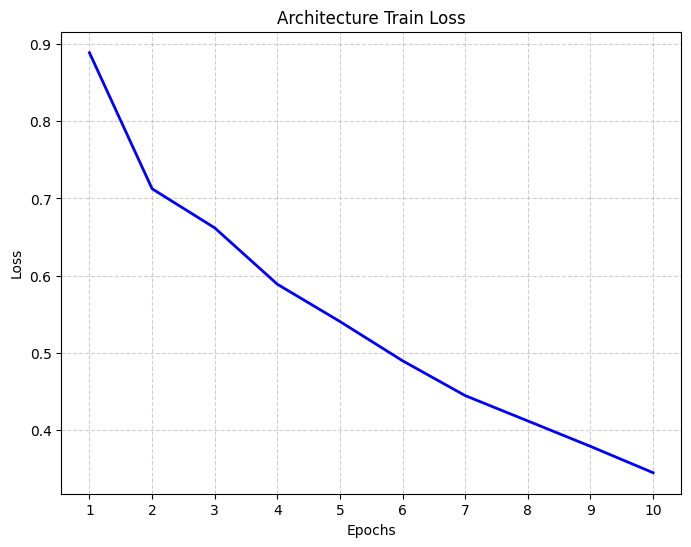

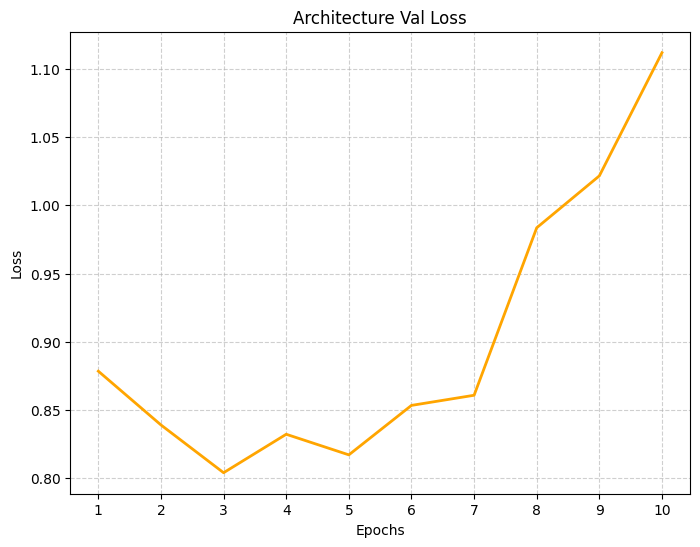

In [ ]:
plot_loss(absa_train_loss_list, "Architecture Train Loss", "blue")
plot_loss(absa_val_loss_list, "Architecture Val Loss", "orange")

In [9]:
def test_architecture(data_path, model_path):
    with open(data_path, 'r', encoding='utf-8') as file:
        test_data = json.load(file)
    test_dataset = ABSADataset(test_data, label_map)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
    
    model = ABSAModel()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for batch in test_dataloader:
            tokens, aspect, labels = batch
            tokens, aspect, labels = tokens.to(device), aspect.to(device), labels.to(device)

            outputs = model(tokens, aspect)

            _, predicted = torch.max(outputs, dim=1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

    test_acc = test_correct / test_total
    print(f"Accuracy: {test_acc*100:.2f}%")

test_architecture('val_task_2.json', 'ABSAModel.pth')

Accuracy: 68.19%


# Finetuning

In [14]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, data, label_map, tokenizer, max_length=128):
        """
        Args:
            data (list): List of dicts with 'tokens', 'aspect', and 'polarity'.
            label_map (dict): Mapping of sentiment labels to integers.
            tokenizer: BERT tokenizer
            max_length: Maximum tokenized sequence length
        """
        self.data = data
        self.label_map = label_map
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        sentence = " ".join(sample["tokens"])  # Convert token list to string
        aspect = " ".join(sample["aspect_term"])  # Convert aspect list to string
        polarity = self.label_map[sample["polarity"]]  # Convert polarity to label index

        encoded = self.tokenizer(
            sentence, aspect,
            padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt"
        )

        input_ids = encoded["input_ids"].squeeze(0)  # Shape: (max_length,)
        attention_mask = encoded["attention_mask"].squeeze(0)  # Shape: (max_length,)
        label = torch.tensor(polarity, dtype=torch.long)  # Scalar tensor

        return {"input_ids": input_ids, "attention_mask": attention_mask, "label": label}

In [15]:
class BERTClassifier(nn.Module):
    def __init__(self, num_labels=4):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token representation
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits

In [16]:
class BARTClassifier(nn.Module):
    def __init__(self, num_labels, model_name='facebook/bart-base'):
        super(BARTClassifier, self).__init__()
        self.bart = BartModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bart.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bart(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token representation
        cls_output = self.dropout(cls_output)
        logits = self.fc(cls_output)
        return logits

In [17]:
class RoBERTaClassifier(nn.Module):
    def __init__(self, num_labels, model_name='roberta-base'):
        super(RoBERTaClassifier, self).__init__()
        self.roberta = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        
        # Extract the last hidden state if needed
        hidden_states = outputs.hidden_states  # Tuple of all layers
        cls_output = hidden_states[-1][:, 0, :]  # CLS token from last layer
        
        return outputs.logits  # Return model's logits for classification

In [18]:
def finetune(model, tokenizer, path):
    train_dataset = SentimentDataset(train_data, label_map, tokenizer)
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_dataset = SentimentDataset(val_data, label_map, tokenizer)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Optimizer and Loss
    optimizer = optim.Adam(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()

    train_loss_list = []
    val_loss_list = []
    best_val_loss = float("inf")

    # Training loop
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for batch in train_dataloader:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(logits, dim=1)  # Get predicted class
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        train_acc = train_correct / train_total
        avg_train_loss = train_loss / len(train_dataloader)

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)

                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)

                val_loss += loss.item()
                _, predicted = torch.max(logits, dim=1)  # Get predicted class
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
            
        val_acc = val_correct / val_total
        avg_val_loss = val_loss / len(val_dataloader)

        train_loss_list.append(avg_train_loss)
        val_loss_list.append(avg_val_loss)
            
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), path)

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
        f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return train_loss_list, val_loss_list

In [ ]:
bert_model = BERTClassifier(num_labels=4).to(device)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_train_loss_list, bert_val_loss_list = finetune(bert_model, bert_tokenizer, "finetunedBERT.pth")

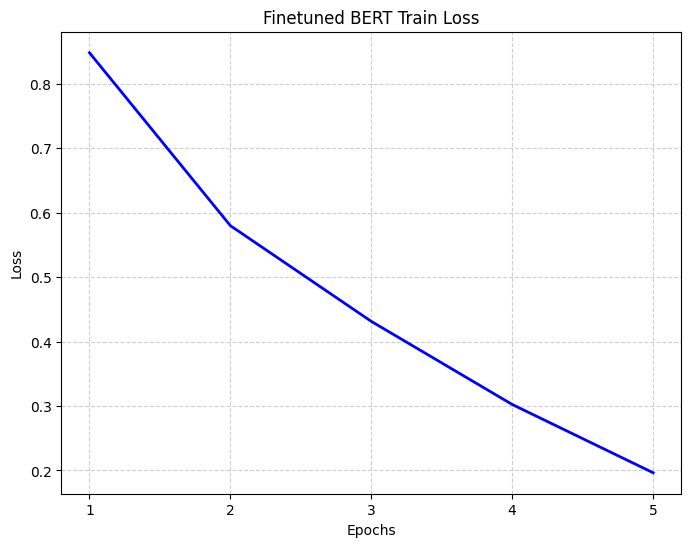

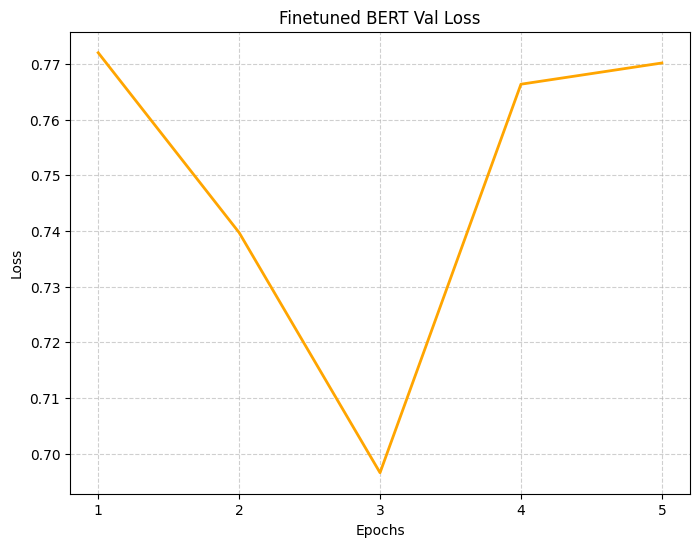

In [18]:
plot_loss(bert_train_loss_list, "Finetuned BERT Train Loss", "blue")
plot_loss(bert_val_loss_list, "Finetuned BERT Val Loss", "orange")

In [16]:
bart_model = BARTClassifier(num_labels=4).to(device)
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
bart_train_loss_list, bart_val_loss_list = finetune(bart_model, bart_tokenizer, "finetunedBART.pth")

Epoch [1/5] - Train Loss: 1.0622, Train Acc: 0.5907 | Val Loss: 0.8553, Val Acc: 0.6819
Epoch [2/5] - Train Loss: 0.7714, Train Acc: 0.7133 | Val Loss: 0.9023, Val Acc: 0.6927
Epoch [3/5] - Train Loss: 0.7006, Train Acc: 0.7416 | Val Loss: 0.8142, Val Acc: 0.7008
Epoch [4/5] - Train Loss: 0.6015, Train Acc: 0.7808 | Val Loss: 0.7913, Val Acc: 0.6981
Epoch [5/5] - Train Loss: 0.5532, Train Acc: 0.7987 | Val Loss: 0.7788, Val Acc: 0.7035


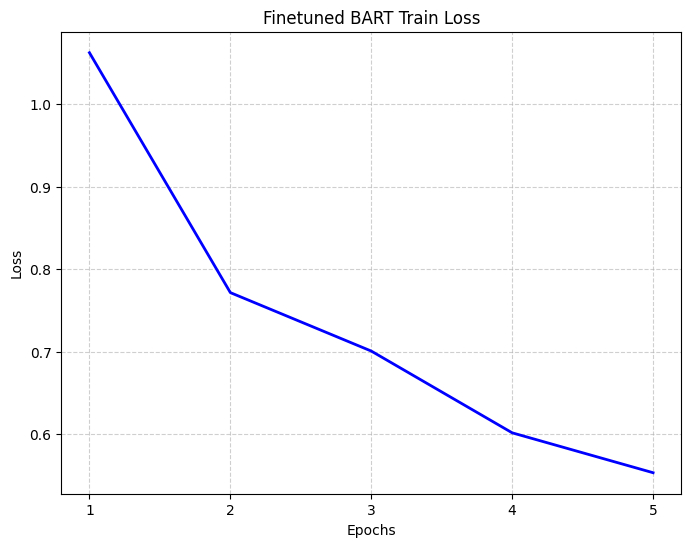

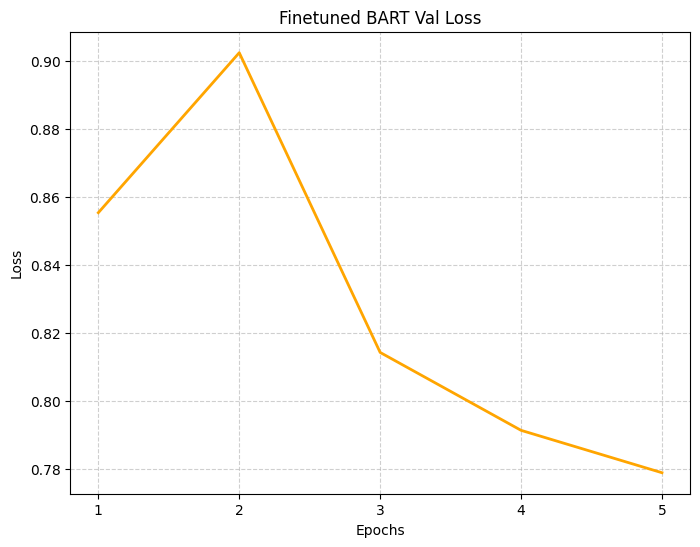

In [17]:
plot_loss(bart_train_loss_list, "Finetuned BART Train Loss", "blue")
plot_loss(bart_val_loss_list, "Finetuned BART Val Loss", "orange")

In [20]:
roberta_model = RoBERTaClassifier(num_labels=4).to(device)
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_train_loss_list, roberta_val_loss_list = finetune(roberta_model, roberta_tokenizer, "finetunedRoBERTa.pth")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5] - Train Loss: 0.8957, Train Acc: 0.6525 | Val Loss: 0.8096, Val Acc: 0.6496
Epoch [2/5] - Train Loss: 0.6252, Train Acc: 0.7528 | Val Loss: 0.7137, Val Acc: 0.7466
Epoch [3/5] - Train Loss: 0.4623, Train Acc: 0.8332 | Val Loss: 0.7019, Val Acc: 0.7574
Epoch [4/5] - Train Loss: 0.3346, Train Acc: 0.8808 | Val Loss: 0.6696, Val Acc: 0.7628
Epoch [5/5] - Train Loss: 0.2429, Train Acc: 0.9125 | Val Loss: 0.9071, Val Acc: 0.7358


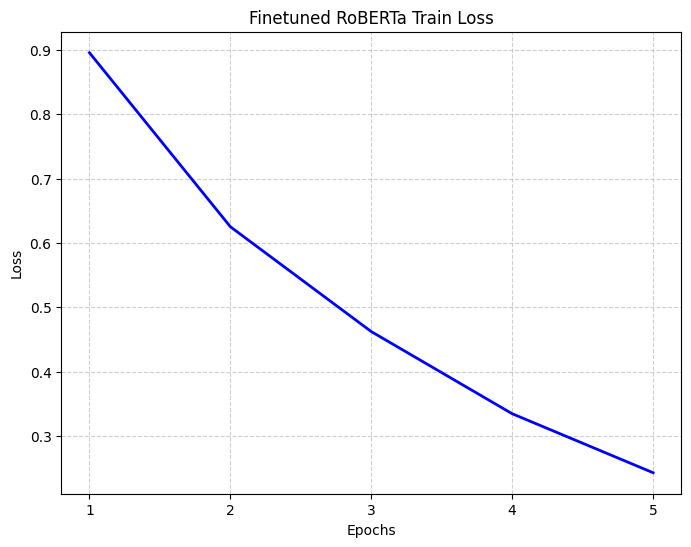

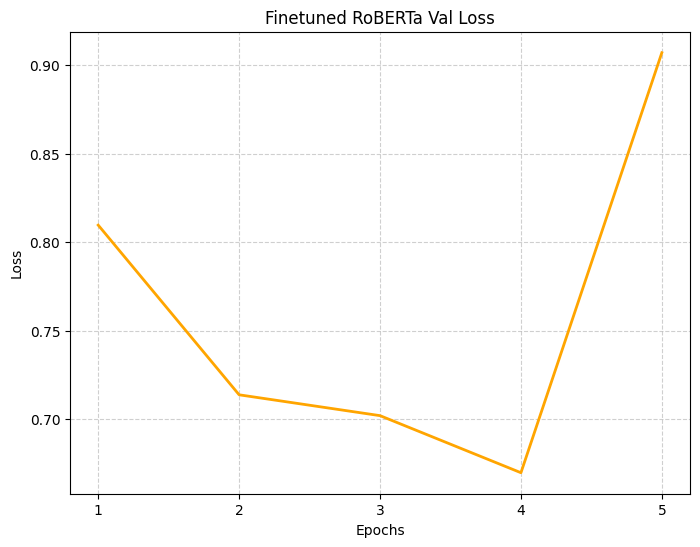

In [21]:
plot_loss(roberta_train_loss_list, "Finetuned RoBERTa Train Loss", "blue")
plot_loss(roberta_val_loss_list, "Finetuned RoBERTa Val Loss", "orange")

In [22]:
def test_finetuned(data_path, model_class, tokenizer, model_path):
    with open(data_path, 'r', encoding='utf-8') as file:
        test_data = json.load(file)
    test_dataset = SentimentDataset(test_data, label_map, tokenizer)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

    model = model_class(num_labels=4)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    test_correct, test_total = 0, 0
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids, attention_mask)

            _, predicted = torch.max(logits, dim=1)  # Get predicted class
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
        
    test_acc = test_correct / test_total
    print(f"finetuned {model_path[9:-4]} Accuracy: {test_acc*100:.2f}%")

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

test_finetuned('val_task_2.json', BERTClassifier, bert_tokenizer, 'finetunedBERT.pth')
test_finetuned('val_task_2.json', BARTClassifier, bart_tokenizer, 'finetunedBART.pth')
test_finetuned('val_task_2.json', RoBERTaClassifier, roberta_tokenizer, 'finetunedRoBERTa.pth')

finetuned BERT Accuracy: 74.39%
finetuned BART Accuracy: 70.35%


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


finetuned RoBERTa Accuracy: 76.28%


In [19]:
print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"Cached: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")


Allocated: 0.00 MB
Cached: 0.00 MB
